In [1]:
import os
import pandas as pd

# Imports the method used for connecting to DBs
from sqlalchemy import create_engine, inspect

# Imports the methods needed to abstract classes into tables
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import Column, Integer
from sqlalchemy.orm import Session
from sqlalchemy import func

In [2]:
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
style.use('fivethirtyeight')

In [3]:
import datetime as dt
import numpy as np

In [4]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")
Base = automap_base()


In [5]:
Base.prepare(engine, reflect=True)

In [6]:
Base.classes.keys()

['measurements', 'stations']

In [7]:
# Using the inspector to print the column names within the table and its types
inspector = inspect(engine)

print("table names")
print(inspector.get_table_names())
columns = inspector.get_columns('measurements')

print("Table measurements")
for column in columns:
    print(column["name"], column["type"])

print("____________________")
print("Table stations")
columns = inspector.get_columns('stations')
for column in columns:
    print(column["name"], column["type"])

table names
['measurements', 'stations']
Table measurements
index INTEGER
station VARCHAR(255)
date VARCHAR(255)
precipitation FLOAT
tobs INTEGER
____________________
Table stations
index INTEGER
station VARCHAR(255)
name VARCHAR(255)
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Assign the measurements class to a variable called `Demographics`
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [9]:
# Create a session
session = Session(engine)

In [10]:
rows = (session
        .query(Stations.station)
        .limit(5)
        .all())
for row in rows:
    print(row)

('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)


In [11]:
results = (session.query(Measurements.date, Measurements.precipitation)
            .filter(Measurements.date > "2010-01-1")
            .filter(Measurements.date < "2010-12-31")
            .limit(5)
            .all()
            )

results

[('2010-01-10', 0.0),
 ('2010-01-11', 0.01),
 ('2010-01-12', 0.0),
 ('2010-01-14', 0.0),
 ('2010-01-15', 0.0)]

## Precipitation Analysis

In [12]:
today = dt.date.today()
twelve_months_ago = dt.date.today() - dt.timedelta(days=365)
print(today)
print(twelve_months_ago)


2018-07-28
2017-07-28


In [13]:
results = (session.query(Measurements.date, Measurements.precipitation)
            .filter(Measurements.date > twelve_months_ago)
            .filter(Measurements.date < today)
            .order_by(Measurements.date)
            .all()
           )

In [14]:
df = pd.DataFrame(results,columns=['Dates','Precipitations'])
#df.set_index('Dates',inplace=True)
#df.index = pd.to_datetime(df.index)
df.Dates = pd.to_datetime(df.Dates)
df.head()

,Dates,Precipitations
0,2017-07-29,0.00
1,2017-07-29,0.06
2,2017-07-29,0.02
3,2017-07-29,0.00
4,2017-07-29,0.23


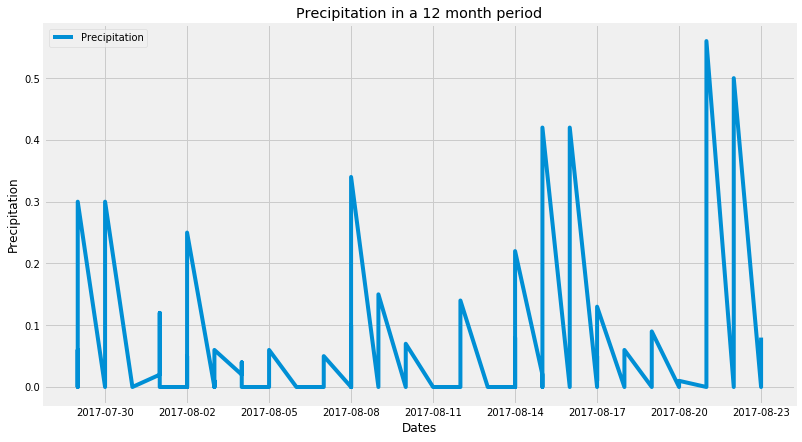

In [15]:
#plt.style.use('seaborn')
plt.figure(figsize=(12,7))
plt.plot(df["Dates"], df["Precipitations"], label='Precipitation')

plt.xlabel('Dates')
plt.ylabel('Precipitation')
plt.title("Precipitation in a 12 month period")
plt.legend()
plt.show()

## Summary Staticstics

In [16]:
df.describe()

,Precipitations
count,96.000000
mean,0.058750
std,0.117198
min,0.000000
25%,0.000000
50%,0.000000
75%,0.060000
max,0.560000


## Station Analysis

### Total Stations 

In [17]:
station_count = (session
                .query(Measurements.station)
                .group_by(Measurements.station)
                .count()
                )
print(station_count)

9


### Most Active Station

In [18]:
active_stations = (session
                 .query(Measurements.station, func.count(Measurements.station))
                 .group_by(Measurements.station)
                 .order_by(func.count(Measurements.station).desc())
                 .all())

print("Highest Number of observations: " + str(active_stations[0]))
print("\b")

print("Active Stations in Descending Order:")
for station in active_stations:
    print(station)

Highest Number of observations: ('USC00519281', 2772)

Active Stations in Descending Order:
('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2483)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


### 12 Months of Temperature Observation Data

In [19]:
query_tobs = (session.query(Measurements.date, Measurements.station, Measurements.tobs)
            .filter(Measurements.date > twelve_months_ago)
            .filter(Measurements.date < today)
            .order_by(Measurements.tobs.desc())
            .all()
            )

print(query_tobs[0])

('2017-07-30', 'USC00519523', 84)


In [20]:
tobs_df = pd.DataFrame(query_tobs,columns=['Date','Stations','Tobs'])
tobs_df.Date = pd.to_datetime(tobs_df.Date)
tobs_df.head()


,Date,Stations,Tobs
0,2017-07-30,USC00519523,84
1,2017-08-13,USC00519523,84
2,2017-07-29,USC00519523,83
3,2017-08-02,USC00519523,83
4,2017-08-06,USC00519523,83


No handles with labels found to put in legend.


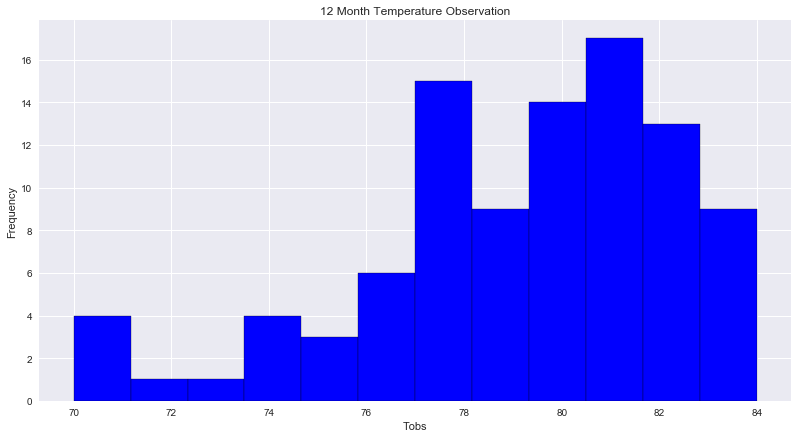

In [21]:
num_bins = 12
plt.style.use('seaborn')
plt.figure(figsize=(12,7))
plt.hist(tobs_df["Tobs"], num_bins, color = 'blue', edgecolor = 'black')

plt.xlabel('Tobs')
plt.ylabel('Frequency')
plt.title("12 Month Temperature Observation")
plt.legend()
plt.show()

## Temperature Analysis

In [22]:
def checkDate(date):
    try:
        date = dt.datetime.strptime(date,"%Y-%m-%d")
        return date
    except Exception as e:
        print(e)
        print("The Entry is not a valid date!!!!")
        print("Try again !")
        getDates()


In [23]:
def getDates():
    start_date = input("Enter the Start Date: YYYY-MM-DD ")
    start_date = checkDate(start_date)
    end_date = input("Enter the End Date: YYYY-MM-DD ")
    end_date = checkDate(end_date)
    
    return{"start_date":start_date,"end_date":end_date}

In [24]:
def calc_temps(begin, end):
    query_tobs = (session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs))
            .filter(Measurements.date > begin)
            .filter(Measurements.date < end)
            .all()
            )
    
    print("Mininim for the date range is: " + str(query_tobs[0][0]))
    print("Maximum for the date range is: " + str(query_tobs[0][1]))
    print("Average for the date range is: " + str(query_tobs[0][2]))
    
    plot_bar(query_tobs[0][2], query_tobs[0][1], query_tobs[0][0])
    

In [25]:
def getTempDesc():
    dates = getDates()
    begin_date = dates["start_date"]
    begin_date = f"{begin_date:%Y-%m-%d}"
    
    end_date = dates["end_date"]
    end_date = f"{end_date:%Y-%m-%d}"
    
    print("\b")
    print("The Entered Year Range Data:\b")
    print("\b")
    print("Start date is :" + begin_date)
    print("End date is :" + end_date)
    print("\b")
    print("\b")
    calc_temps(begin_date, end_date)
    print("\b")
    
    #get year range for 1 year before provided date
    print("The Prior Year Data:\b")
    prior_start_date = dates["start_date"] - dt.timedelta(days=365)
    prior_start_date = f"{prior_start_date:%Y-%m-%d}"
    
    prior_end_date = dates["start_date"]
    prior_end_date = f"{prior_end_date:%Y-%m-%d}"
    
    print("\b")
    print("Start date for Prior year is :" + prior_start_date)
    print("End date for Prior year is:" + prior_end_date)
    print("\b")
    
    calc_temps(prior_start_date, prior_end_date)

In [28]:
def plot_bar(avg, maximum, minimum):
    x = (1)
    y = avg
    err = maximum - minimum

    fig, ax = plt.subplots()

    index = np.arange(1)
    bar_width = 0.2

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax.bar(x, y, bar_width,
                    alpha=opacity, color='b',
                    yerr=err, error_kw=error_config,
                    label='Average')

    ax.set_xlabel('Range')
    ax.set_ylabel('Average Temperature')
    ax.set_title('Average Temperature for Year')
    ax.set_xticks(index + bar_width / 2)
    ax.legend()
    fig.tight_layout()
    plt.show()

#### Temperature Report For Entered Date and Year Prior to that

Enter the Start Date: YYYY-MM-DD 2012-12-23
Enter the End Date: YYYY-MM-DD 2013-12-23

The Entered Year Range Data

Start date is :2012-12-23
End date is :2013-12-23


Mininim for the date range is: 53
Maximum for the date range is: 86
Average for the date range is: 72.51462225832657


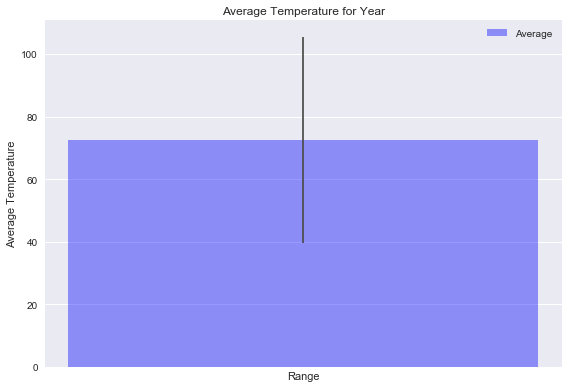


The Prior Year Data:

Start date for Prior year is :2011-12-24
End date for Prior year is:2012-12-23

Mininim for the date range is: 56
Maximum for the date range is: 86
Average for the date range is: 72.25385865150284


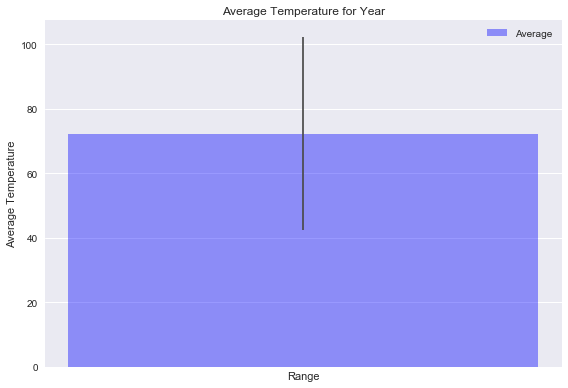

In [29]:
getTempDesc()
